# 고금계 과제 1 데이터 정리 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [28]:
CWD = Path('.').resolve()
DATA_DIR = CWD / 'data'

## 데이터 로드

In [75]:
fn1 = DATA_DIR / '고금계과제1_v3.3_201301-202408.csv'

In [76]:
## 추출한 fnguide 데이터를 dataframe으로 전처리

def preprocess_dataguide_csv(
        fn_file_path, 
        cols=['Symbol', 'Symbol Name', 'Kind', 'Item', 'Item Name ', 'Frequency',], # 날짜가 아닌 컬럼들
        skiprows=8, 
        encoding="cp949",
        ):
    fn_df = pd.read_csv(fn_file_path, encoding=encoding, skiprows=skiprows, thousands=",")
    fn_df = fn_df.melt(id_vars=cols, var_name="date", value_name="value")

    return fn_df

In [77]:
fn1_df = preprocess_dataguide_csv(fn1, encoding='utf-8')

In [78]:
fn1_df

,Symbol,Symbol Name,Kind,Item,Item Name,Frequency,date,value
0,A005930,삼성전자,SSC,S41000060F,종가(원),DAILY,2013-01-31,"1,448,000"
1,A005930,삼성전자,SSC,S410001600,수정계수,DAILY,2013-01-31,1.000000
2,A005930,삼성전자,SSC,S410000700,수정주가(원),DAILY,2013-01-31,"28,960"
3,A005930,삼성전자,SSC,S41000180F,수익률 (1개월)(%),DAILY,2013-01-31,-4.86
4,A005930,삼성전자,COM,CP10000600,FnGuide Sector,NaN,2013-01-31,IT
...,...,...,...,...,...,...,...,...
9489577,A950180,SNK,NFS-IFRS(C),6000905001,매출원가(천원),ANNUAL,2024-09-19,NaN
9489578,A950180,SNK,NFS-IFRS(C),6000909054,이자비용(천원),ANNUAL,2024-09-19,NaN
9489579,A950180,SNK,NFS-IFRS(C),6000906001,영업이익(천원),ANNUAL,2024-09-19,NaN
9489580,A950180,SNK,NFS-IFRS(C),6000901001,총자산(천원),ANNUAL,2024-09-19,NaN


In [79]:
items = fn1_df['Item Name '].unique() # 원래부터 DataGuide에 띄어쓰기가 들어가 있어서 'Item Name '

In [80]:
# Mappings

symbol_to_name = fn1_df[['Symbol', 'Symbol Name']].drop_duplicates().set_index('Symbol').to_dict()['Symbol Name']
name_to_symbol = {v:k for k, v in symbol_to_name.items()}

In [81]:
def get_panel_df(molten_df, item_name):
    panel_df = molten_df.loc[molten_df['Item Name '] == item_name]
    panel_df = panel_df.pivot(index='date', columns='Symbol', values='value')
    panel_df = panel_df.reset_index()
    
    panel_df = panel_df.set_index('date', inplace=False)
    panel_df.sort_index(inplace=True)
    
    return panel_df 

## 전처리 (1차)

### 기간 내 존재하지 않는 기업 제외

In [82]:
adj_close_temp = get_panel_df(fn1_df, '수정주가(원)')

In [83]:
adj_close_temp.head()

Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,NaN,"6,030",NaN,"8,727","7,874","13,300","67,800","32,000",NaN,"25,873",...,"3,885",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,NaN,"6,030",NaN,"8,215","8,220","11,600","69,400","34,100",NaN,"25,168",...,"4,310",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,NaN,"6,110",NaN,"8,162","8,456","11,950","70,700","33,850",NaN,"26,930",...,"4,065",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,"6,750",NaN,"8,162","10,650","11,950","93,600","32,250",NaN,"29,609",...,"6,100",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,NaN,"6,930",NaN,"8,550","12,425","13,200","88,000","31,800",NaN,"26,155",...,"6,260","11,900",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
adj_close_temp.shape

(141, 3739)

In [85]:
adj_close_temp.dropna(axis=1, how='all', inplace=True)

In [86]:
adj_close_temp.shape

(141, 2927)

In [87]:
# 분석 기간 내 존재했던 종목들
univ_list = adj_close_temp.columns

### 기타 조건별 제외

In [88]:
def filter_univ(univ_list, panel_df, is_copy=True):
    if is_copy:
        return panel_df[univ_list].copy()
    else:
        return panel_df[univ_list]

#### 금융주 제외

<Axes: xlabel='date'>

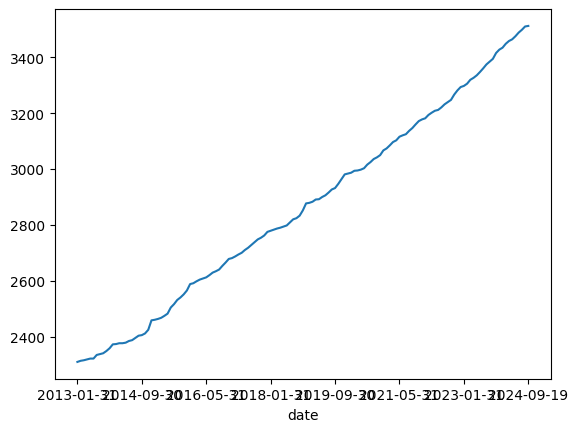

In [89]:
sector_all_df = get_panel_df(fn1_df, 'FnGuide Sector')
sector_all_df.count(axis=1).plot()

In [90]:
sector_df = filter_univ(univ_list, get_panel_df(fn1_df, 'FnGuide Sector') )
sector_df.head()

Symbol,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000100,A000120,A000140,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,의료,금융,경기소비재,경기소비재,금융,산업재,필수소비재,의료,산업재,필수소비재,...,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,의료,금융,경기소비재,경기소비재,금융,산업재,필수소비재,의료,산업재,필수소비재,...,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,의료,금융,경기소비재,경기소비재,금융,산업재,필수소비재,의료,산업재,필수소비재,...,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,의료,금융,경기소비재,경기소비재,금융,산업재,필수소비재,의료,산업재,필수소비재,...,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,의료,금융,경기소비재,경기소비재,금융,산업재,필수소비재,의료,산업재,필수소비재,...,IT,의료,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# 섹터는 고정되어있지 않고 중간에 바뀌기도 함. 
sector_df.nunique()[sector_df.nunique() != 1].sort_values(ascending=False)

Symbol
A141020    4
A222810    4
A065560    4
A078940    4
A056730    4
          ..
A064820    2
A008060    2
A008260    2
A063760    2
A089230    2
Length: 446, dtype: int64

In [92]:
univ_df = ~sector_df.isnull() & (sector_df != '금융')

#### 관리종목, 거래정지 제외

In [46]:
is_under_supervision_df = filter_univ(univ_list, get_panel_df(fn1_df, '관리종목여부') )
is_trading_halt_df = filter_univ(univ_list, get_panel_df(fn1_df, '거래정지여부') )

In [47]:
is_under_supervision_mapping = {
    '정상': True,
    '관리': False,
}
is_trading_halt_mapping = {
    '정상': True,
    '정지': False,
}

In [48]:
is_under_supervision_df = is_under_supervision_df.replace(is_under_supervision_mapping).infer_objects(copy=False)
is_trading_halt_df = is_trading_halt_df.replace(is_trading_halt_mapping).infer_objects(copy=False)

C:\Users\chlje\AppData\Local\Temp\ipykernel_32920\2032458651.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_under_supervision_df = is_under_supervision_df.replace(is_under_supervision_mapping).infer_objects(copy=False)
C:\Users\chlje\AppData\Local\Temp\ipykernel_32920\2032458651.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_trading_halt_df = is_trading_halt_df.replace(is_trading_halt_mapping).infer_objects(copy=False)


In [49]:
univ_df = univ_df & is_under_supervision_df & is_trading_halt_df

In [50]:
# Update univ_list
univ_list = univ_df.columns

## 데이터셋 생성

### 시장

In [51]:
close_df = filter_univ(univ_list, get_panel_df(fn1_df, '종가(원)') ) 
adjclose_df = filter_univ(univ_list, get_panel_df(fn1_df, '수정주가(원)') )
adjfactor_df = filter_univ(univ_list, get_panel_df(fn1_df, '수정계수') )
monthly_returns_df = filter_univ(univ_list, get_panel_df(fn1_df, '수익률 (1개월)(%)') ) # 수익률은 %로 되어있어 뒤에서 /100 해줘야 함.

all_mkt_cap_df = filter_univ(univ_list, get_panel_df(fn1_df, '시가총액 (상장예정주식수 포함)(백만원)') )
common_mkt_cap_df = filter_univ(univ_list, get_panel_df(fn1_df, '시가총액 (보통-상장예정주식수 포함)(백만원)') )
common_shares_outstanding_df = filter_univ(univ_list, get_panel_df(fn1_df, '기말발행주식수 (보통)(주)') )

is_under_supervision_df = filter_univ(univ_list, get_panel_df(fn1_df, '관리종목여부') )
is_trading_halt_df = filter_univ(univ_list, get_panel_df(fn1_df, '거래정지여부') )

#### 재무

In [52]:
common_stock_df = filter_univ(univ_list, get_panel_df(fn1_df, '보통주자본금(천원)') )
capital_surplus_df = filter_univ(univ_list, get_panel_df(fn1_df, '자본잉여금(천원)') )
retained_earnings_df = filter_univ(univ_list, get_panel_df(fn1_df, '이익잉여금(천원)') )
treasury_stock_df = filter_univ(univ_list, get_panel_df(fn1_df, '자기주식(천원)') )
deferred_tax_liabilities_df = filter_univ(univ_list, get_panel_df(fn1_df, '이연법인세부채(천원)') )
sales_revenue_df = filter_univ(univ_list, get_panel_df(fn1_df, '매출액(천원)') )
cost_of_goods_sold_df = filter_univ(univ_list, get_panel_df(fn1_df, '매출원가(천원)') )
interest_expense_df = filter_univ(univ_list, get_panel_df(fn1_df, '이자비용(천원)') )
operating_profit_df = filter_univ(univ_list, get_panel_df(fn1_df, '영업이익(천원)') )
total_assets_df = filter_univ(univ_list, get_panel_df(fn1_df, '총자산(천원)') )

In [53]:
total_assets_df

Symbol,A000020,A000030,A000040,A000050,A000060,A000070,A000075,A000080,A000087,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,"316,165,541","340,690,382,000","116,931,646","1,296,989,142","10,172,764,138","2,595,067,569",NaN,"3,553,146,711",NaN,"1,513,968,939",...,"126,398,485","59,189,994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,"316,165,541","340,690,382,000","116,931,646","1,296,989,142","10,172,764,138","2,595,067,569",NaN,"3,553,146,711",NaN,"1,513,968,939",...,"126,398,485","59,189,994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,"316,165,541","340,690,382,000","116,931,646","1,296,989,142","10,172,764,138","2,595,067,569",NaN,"3,553,146,711",NaN,"1,513,968,939",...,"126,398,485","59,189,994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,"316,165,541","340,690,382,000","116,931,646","1,296,989,142","11,052,627,578","2,595,067,569",NaN,"3,553,146,711",NaN,"1,513,968,939",...,"86,879,175","59,189,994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,"316,165,541","340,690,382,000","116,931,646","1,296,989,142","11,052,627,578","2,595,067,569",NaN,"3,553,146,711",NaN,"1,513,968,939",...,"86,879,175","59,189,994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 전처리 (2차)

### 형변환

In [54]:
numeric_data = [
    close_df, adjclose_df, adjfactor_df, monthly_returns_df, all_mkt_cap_df, common_mkt_cap_df, common_shares_outstanding_df,
    common_stock_df, capital_surplus_df, retained_earnings_df, treasury_stock_df, deferred_tax_liabilities_df,
    sales_revenue_df, cost_of_goods_sold_df, interest_expense_df, operating_profit_df, total_assets_df
]

In [55]:
for df in numeric_data:
    obj_cols = df.select_dtypes('object').columns
    df[obj_cols] = df[obj_cols].replace(',', '', regex=True).infer_objects(copy=False) 
    df[obj_cols] = df[obj_cols].apply(pd.to_numeric, errors='coerce')


C:\Users\chlje\AppData\Local\Temp\ipykernel_32920\3004647169.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[obj_cols] = df[obj_cols].replace(',', '', regex=True).infer_objects(copy=False)
C:\Users\chlje\AppData\Local\Temp\ipykernel_32920\3004647169.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[obj_cols] = df[obj_cols].replace(',', '', regex=True).infer_objects(copy=False)
C:\Users\chlje\AppData\Local\Temp\ipykernel_32920\3004647169.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be re

### 단위 통일

In [56]:
monthly_returns_df = monthly_returns_df / 100 # 수익률은 %로 되어있어 /100

In [57]:
all_mkt_cap_df = all_mkt_cap_df * 100 # 시가총액은 100만원 단위라 *100하여 천원 단위로 맞춰줌
common_mkt_cap_df = common_mkt_cap_df * 100

In [58]:
all_mkt_cap_df

Symbol,A000020,A000030,A000040,A000050,A000060,A000070,A000075,A000080,A000087,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,16842700,NaN,5907400,21558400,128611000.0,52950500,NaN,224204700,NaN,206940200,...,8300500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,16842700,NaN,5561300,22505500,112172000.0,54167800,NaN,238908000,NaN,201293100,...,9208500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,17066100,NaN,5525500,23153400,115556500.0,58761000,NaN,237340700,NaN,215262100,...,8685000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,18853700,NaN,5525500,29159900,115556500.0,77524600,NaN,226602800,NaN,236459100,...,13032900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,19356500,NaN,5788100,34019900,133754000.0,72994700,NaN,223238900,NaN,209222700,...,13374700,30940000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,23127300,NaN,4191300,21027500,NaN,61380500,NaN,142770000,NaN,559030300,...,7937300,24910600.0,46689500.0,105916500.0,27166800.0,NaN,14204600.0,9146700.0,47776400.0,17499500.0
2024-06-30,22512800,NaN,3932700,21329100,NaN,60606700,NaN,150898600,NaN,656980700,...,7227800,24146900.0,45497400.0,109895800.0,28098300.0,NaN,13579900.0,7559800.0,51983200.0,15818800.0
2024-07-31,23294800,NaN,3547800,19464800,NaN,61600900,NaN,147704200,NaN,765900700,...,6891100,24837900.0,39715900.0,137533900.0,29133200.0,NaN,14055200.0,8781300.0,83113000.0,14484100.0
